In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 26421880/26421880 [00:07<00:00, 3740468.78it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 350941.27it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6385235.36it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11837871.16it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [7]:
k = len(set(train_dataset.targets.numpy()))
print("number of classes: ", k)

number of classes:  10


In [8]:
class CNN(nn.Module):
    def __init__(self, k):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, k)
        )
        
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [9]:
model = CNN(k)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    test_losses = []
    
    for i in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        dt = datetime.now() - t0
        
        print(f"epoch {i + 1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, duration: {dt}")
        
    return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

epoch 1/15, train_loss: 0.6631, test_loss: 0.4955, duration: 0:00:10.348758
epoch 2/15, train_loss: 0.4381, test_loss: 0.4061, duration: 0:00:11.104602
epoch 3/15, train_loss: 0.3827, test_loss: 0.3777, duration: 0:00:08.780086
epoch 4/15, train_loss: 0.3460, test_loss: 0.3459, duration: 0:00:08.392920
epoch 5/15, train_loss: 0.3216, test_loss: 0.3331, duration: 0:00:08.665730
epoch 6/15, train_loss: 0.3004, test_loss: 0.3214, duration: 0:00:08.435678
epoch 7/15, train_loss: 0.2823, test_loss: 0.3207, duration: 0:00:08.331337
epoch 8/15, train_loss: 0.2681, test_loss: 0.3053, duration: 0:00:08.655096
epoch 9/15, train_loss: 0.2524, test_loss: 0.3119, duration: 0:00:08.507564
epoch 10/15, train_loss: 0.2377, test_loss: 0.2983, duration: 0:00:08.308837
epoch 11/15, train_loss: 0.2250, test_loss: 0.2940, duration: 0:00:08.526790
epoch 12/15, train_loss: 0.2146, test_loss: 0.2993, duration: 0:00:08.489436
epoch 13/15, train_loss: 0.2021, test_loss: 0.2833, duration: 0:00:08.257480
epoch 14

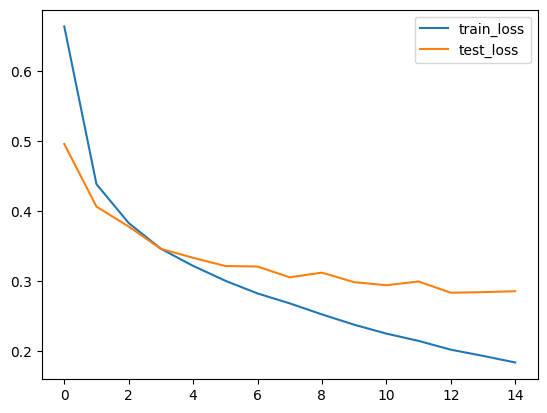

In [15]:
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [16]:
model.eval()

def calculate_acc(data_loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    acc = n_correct / n_total
    return acc

In [17]:
train_acc = calculate_acc(train_loader)
test_acc = calculate_acc(test_loader)

print(f"train_acc: {train_acc}, test_acc: {test_acc}")

train_acc: 0.9501166666666667, test_acc: 0.9014


In [18]:
def plot_confusion_matrix_sns(cm,
                          labels,  
                          normalized=False, 
                          title="confusion_matrix", 
                          cmap=plt.cm.Blues):
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print("confusion_matrix without normalization")
        
    print(cm)
    
    fmt = '.2f' if normalized else 'd'
    
    sns.heatmap(cm, cmap=cmap, annot=True, fmt=fmt, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.tight_layout()
    # plt.xticks(classes, labels, rotation=90)
    # plt.yticks(classes, labels, rotation=0)
    plt.ylabel("True label")
    plt.xlabel("predicted label")
    plt.show()

In [19]:
labels = '''t-shirt/top
trouser
pullover
dress
coat
snadal
shirt
sneaker
bag
ankle_boot'''.split("\n")

confusion_matrix without normalization
[[880   1  30  10   3   1  66   0   9   0]
 [  2 980   0  10   2   0   3   0   3   0]
 [ 17   0 861  11  57   0  52   0   2   0]
 [ 20   5  15 903  35   0  21   0   1   0]
 [  1   1  54  22 857   0  64   0   1   0]
 [  1   0   0   0   0 971   0  15   1  12]
 [138   0  71  19  83   0 679   0  10   0]
 [  0   0   0   0   0  11   0 948   0  41]
 [  1   1   5   5   6   1   4   3 973   1]
 [  0   0   0   0   0   7   1  30   0 962]]


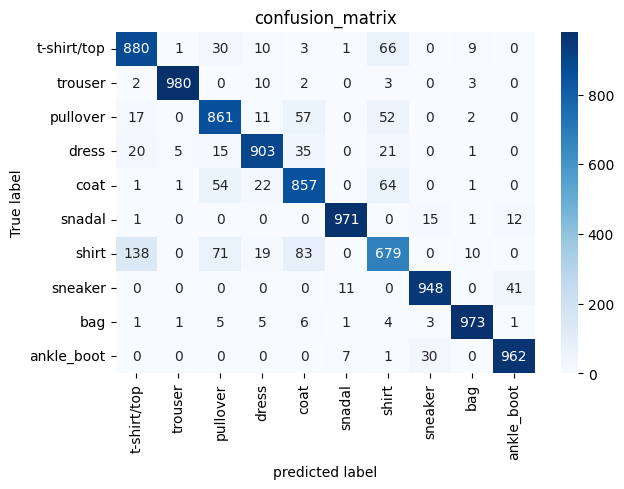

In [20]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
# classes = np.sort(np.unique(y_test))
cm = confusion_matrix(y_test, p_test, labels=np.sort(np.unique(y_test)))
plot_confusion_matrix_sns(cm, labels)

In [21]:
p_test

array([9., 2., 1., ..., 8., 1., 5.])

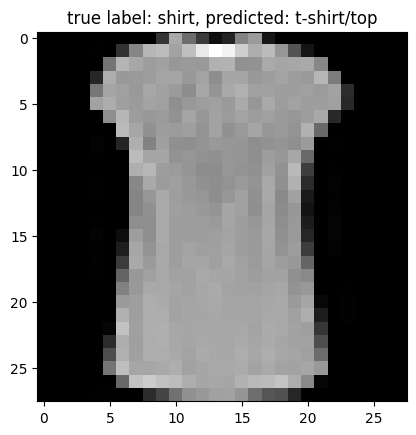

In [22]:
misclassified_index = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_index)
plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
plt.title(f"true label: {labels[y_test[i]]}, predicted: {labels[int(p_test[i])]}")
plt.show()